In [1]:
%load_ext autoreload
%autoreload 2

# Analyse result of simulating mutational robustness of sRNA-mRNA 

## Imports

In [2]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_multiple_as_list, load_json_as_dict
from synbio_morpher.utils.evolution.mutation import mutation_type_mapping_RNA
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


# Combine data from multi-thread

## Simulation settings

In [3]:
# config = {
#     "experiment": {
#         "purpose": "tests",
#     },
#     "system_type": "RNA",
#     "include_prod_deg": False,
#     "interaction_simulator": {
#         "name": "IntaRNA",
#         "postprocess": True,
#         "multithread": 0,
#         "simulator_kwargs": {
#             "outcsvcols": "id1,id2,E,E_norm,subseqDB,Pu1,Pu2"
#         }
#     },
#     "mutations_args": {
#         "algorithm": "all",
#         "mutation_counts": 0,
#         "mutation_nums_within_sequence": [1],
#         "mutation_nums_per_position": 1,
#         "concurrent_species_to_mutate": "single_species_at_a_time",
#         "seed": 0
#     },
#     "simulation": {
#         "dt0": 0.1,
#         "t0": 0,
#         "t1": 100,
#         "tmax": 2000,
#         "solver": "diffrax",
#         "use_batch_mutations": True,
#         "interaction_factor": 1,
#         "batch_size": 200,
#         "max_circuits": 2000,
#         "device": "cpu",
#         "threshold_steady_states": 0.05,
#         "use_rate_scaling": True
#     },
#     "molecular_params": {
#         "avg_mRNA_per_cell": 100,
#         "cell_doubling_time": 1200,
#         "creation_rate": 2.35,
#         "starting_copynumbers": 200,
#         "degradation_rate": 0.01175,
#         "association_binding_rate": 1000000
#     }
# }

# data_writer = None
# config, data_writer = script_preamble(config, data_writer)
# config_file = expand_config(config=config)
# config_file = prepare_config(config_file)

## Load data

In [4]:
fn = '../data/sRNA/merged_inter.csv'
data = pd.read_csv(fn)
try:
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass
data = data[data['Sequence 1'].apply(lambda x: type(x) == str)]
data = data[data['Sequence 2'].apply(lambda x: type(x) == str)]
data

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB,Genome position 1,Genome position 2,Strand 1,Strand 2,Sequence before 1,Sequence before 2,Sequence after 1,Sequence after 2
0,dsrA,dsrB,NCBI:946470,NCBI:946468,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,TAAATGNAAACAAGTTTTATTTTTATCATCAGAACATTCTAATAAA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,atcgttttcctcctgtggctttgtgccagtgtagaacaatttcgtt...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,NaN
1,dsrA,ilvH,NCBI:946470,NCBI:947267,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...
2,oxyS,fhlA,NCBI:2847701,NCBI:947181,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...
3,sgrS,hfq,NCBI:4056038,NCBI:948689,sRNA,mRNA,NaN,NaN,NaN,GATGAAGCAAGGGGGTGCCCCATGCGTCAGTTTTATCAGCACTATT...,ATGGCTAAGGGGCAATCTTTACAAGATCCGTTCCTGAACGCACTGC...,RNAInter,NaN,NaN,NaN,NaN,ttgagcagggtgcgcatatgacgacgcgagcagctcaataacgctg...,cgaagcggcagataacctggctgcgtggttgggaaggggttcactg...,ttattctcgccgcgctaaaaagggaacgtatgatctggataatgac...,aaggtttcgggctgtttttttacacggggagccagcgatcctgcgt...
4,oxyS,nusG,NCBI:2847701,NCBI:948485,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,ATGTCTGAAGCTCCTAAAAAGCGCTGGTACGTCGTTCAGGCGTTTT...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,cgacaaaaggtaaagctaccgttgcttttgcccgtgaagcgcgtac...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,aacccagcgatcaaaaaagcggcgatttaatcgttgcacaaggcgt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,ryhB,msrA,"chromosome:NC_000913.3, Gene ID:2847761","chromosome:NC_000913.3, Gene ID:948734",sRNA,mRNA,No Interaction,['NA'],['NA'],GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase,3580927..3581016,4441538..4442176,reverse,reverse,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,atggtgtcgctctcccgaaaatcggtcattggggttaaggttgtaa...,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,aggtactgtaaagccgccagagggttaaaattcagacagctgaaaa...
374,gcvB,hdeA,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948025",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase,2942696..2942901,3656408..3656740,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,atcgtaatatcctcaactataaagtgaaagagccgtcacgaatcaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,gccaacgcagattgtgcgttcaccagtgacaaagccgctacagcgc...
375,gcvB,hdeB,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948026",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase,2942696..2942901,3655966..3656292,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,attttgtaacccattcaatatagagattatatatgaacaggaggaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,cataaacagggcgcttcccatgccaattaatacatgtgtgcgtaac...
376,Esr41,fliC,"chromosome:NC_002695.1, Gene ID:","chromosome:NC_002695.1, Gene ID:",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],GATGCTCTAGGCATCACATTTTCTCCATGGGGTATTCCCTCCGCCG...,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBa

In [202]:
# source_dirs = [
#     "data/tests/2024_01_21_201544",
#     "data/tests/2024_01_21_201545",
#     "data/tests/2024_01_21_201546",
#     "data/tests/2024_01_21_201547",
#     "data/tests/2024_01_21_201548",
#     "data/tests/2024_01_21_201549",
#     "data/tests/2024_01_21_201550",
#     "data/tests/2024_01_21_201551",
#     "data/tests/2024_01_21_201552",
#     "data/tests/2024_01_21_201553",
#     "data/tests/2024_01_21_201554",
#     "data/tests/2024_01_21_201555",
#     "data/tests/2024_01_21_201557",
#     "data/tests/2024_01_21_201558",
#     "data/tests/2024_01_21_201559",
#     "data/tests/2024_01_21_201601",
#     "data/tests/2024_01_21_201602",
#     "data/tests/2024_01_21_201604",
#     "data/tests/2024_01_21_201605",
#     "data/tests/2024_01_21_201606",
#     "data/tests/2024_01_21_201607",
#     "data/tests/2024_01_21_201608",
#     "data/tests/2024_01_21_201609"
# ]
source_dirs = [
    'data/tests/2024_01_29_175117',
    'data/tests/2024_01_29_175120',
    'data/tests/2024_01_29_175123',
    'data/tests/2024_01_29_175126',
    'data/tests/2024_01_29_175129',
    'data/tests/2024_01_29_175132',
    'data/tests/2024_01_29_175136',
    'data/tests/2024_01_29_175139',
    'data/tests/2024_01_29_175142',
    'data/tests/2024_01_29_175145',
    'data/tests/2024_01_29_175148',
    'data/tests/2024_01_29_175151',
    'data/tests/2024_01_29_175154',
    'data/tests/2024_01_29_175157',
    'data/tests/2024_01_29_175201',
    'data/tests/2024_01_29_175204',
    'data/tests/2024_01_29_175207',
    'data/tests/2024_01_29_175210',
    'data/tests/2024_01_29_175213',
    'data/tests/2024_01_29_175216',
    'data/tests/2024_01_29_175219',
    'data/tests/2024_01_29_175223',
    'data/tests/2024_01_29_175226',
    'data/tests/2024_01_29_175229'
]

### Edit mutation csv's

In [203]:
# # Correcting mistakenly overwritten mutation files

# too_few = []
# too_many = []
# for topdir in source_dirs:
#     for circuit_dir in sorted(os.listdir(topdir)):
#         if os.path.isdir(os.path.join(topdir, circuit_dir, 'mutations')):
#             fn_muts = os.path.join(topdir, circuit_dir, 'mutations_og.csv')
#             fn_muts_new = os.path.join(topdir, circuit_dir, 'mutations.csv')
#             if os.path.isfile(fn_muts):
#                 mutations = pd.read_csv(fn_muts, index_col='mutation_name')
#                 mutations_new = pd.read_csv(fn_muts_new, index_col='mutation_name')
#                 actual_mutations = sorted(os.listdir(os.path.join(topdir, circuit_dir, 'mutations')))
#                 if len(actual_mutations) > len(mutations):
#                     print('less', topdir, circuit_dir)
#                     too_many.append(os.path.join(topdir, circuit_dir))
#                 elif len(actual_mutations) < len(mutations):
#                     print('more', topdir, circuit_dir)
#                     too_few.append(os.path.join(topdir, circuit_dir))
#                 if len(actual_mutations) == len(mutations) and (len(actual_mutations) != len(mutations_new)):
#                     print('correcting', topdir, circuit_dir)
#                     mutations.loc[actual_mutations].to_csv(fn_muts_new)

# # correct the baddies

# correct_dir = 'data/tests/2024_01_21_201551/yagJ_ibsC'

# for circuit_dir in too_few:
#     fn_muts = os.path.join(circuit_dir, 'mutations_og.csv')
#     mutations = pd.read_csv(fn_muts, index_col='mutation_name')
#     mutations_correct = pd.read_csv(os.path.join(correct_dir, 'mutations.csv'), index_col='mutation_name')
#     actual_mutations = sorted(os.listdir(os.path.join(circuit_dir, 'mutations')))
#     if (len(actual_mutations) == len(mutations_correct)) and (len(actual_mutations) > len(mutations)):
#         mutations_correct.to_csv(fn_muts)
#         mutations_correct.to_csv(fn_muts.replace('_og', ''))

# for topdir in source_dirs:
#     for circuit_dir in sorted(os.listdir(topdir)):
#         if circuit_dir == 'yagJ_ascF' and (topdir == 'data/tests/2024_01_21_201602'):
#             print('hmm')
#         if os.path.isdir(os.path.join(topdir, circuit_dir, 'mutations')):
#             fn_muts = os.path.join(topdir, circuit_dir, 'mutations_og.csv')
#             fn_muts_new = os.path.join(topdir, circuit_dir, 'mutations.csv')
#             if not os.path.isfile(fn_muts):
#                 mutations = pd.read_csv(fn_muts_new, index_col='mutation_name')
#                 mutations.to_csv(fn_muts)
#             else:
#                 mutations = pd.read_csv(fn_muts, index_col='mutation_name')
#             actual_mutations = sorted(os.listdir(os.path.join(topdir, circuit_dir, 'mutations')))
#             if len(actual_mutations) != len(mutations):
#                 mutations.loc[actual_mutations].drop_duplicates().to_csv(fn_muts_new)
    
    

In [204]:
def create_dict_of_lists(d: dict, col_names: list) -> dict:
    """ GCG """
    result_dict = {field: [] for field in col_names}
    for subdict in d.values():
        for field, value in subdict.items():
            result_dict[field].append(value)

    return result_dict


def swap_ids(d: dict, l1, l2) -> dict:
    if d['id1'][0] != l1:
        for c in ['id', 'Pu']:
            d[f'{c}1_swap'] = d[f'{c}2']
            d[f'{c}2'] = d[f'{c}1']
            d[f'{c}1'] = d[f'{c}1_swap']
            d.pop(f'{c}1_swap', None)
        d['subseqDB'] = list(
            map(lambda x: '&'.join(x.split('&')[::-1]), d['subseqDB']))
    return d


def process_raw_mutation_dict(d: dict, l1: str, l2: str) -> dict:
    default_inner = {
        "id1": '',
        "id2": '',
        "E": 0.0,
        "E_norm": 0.0,
        "subseqDB": '',
        "Pu1": 0.0,
        "Pu2": 0.0,
        "mutation_name": ''
    }

    def make_uniform(d, l1, l2):
        d = {mut: v.get(l1, v[l2]).get(l2, v[l2][l1])
             if v else {} for mut, v in d.items()}
        for mut, v in d.items():
            if v == {}:
                d[mut] = {k: v for k, v in default_inner.items()}
            d[mut]['mutation_name'] = mut
        return d
    
    def recast_fields(d):
        for c in ['E', 'E_norm', 'Pu1', 'Pu2']:
            d[c] = list(map(lambda x: float(x), d[c]))
        return d

    d = make_uniform(d, l1, l2)
    d = create_dict_of_lists(d, col_names=list(default_inner.keys()))
    d = recast_fields(d)
    d['id1'] = [s for s in set(d['id1']) if s][0]
    d['id2'] = [s for s in set(d['id2']) if s][0]
    d = swap_ids(d, l1, l2)

    return d

In [301]:
saves = pd.DataFrame()
for source_dir in source_dirs: 
    for srna in sorted(os.listdir(source_dir)):
        for mrna in sorted(os.listdir(os.path.join(source_dir, srna))):
            if os.path.isfile(os.path.join(source_dir, srna, mrna, 'inter_data_raw.json')):
                d = load_json_as_dict(os.path.join(source_dir, srna, mrna, 'inter_data_raw.json'))
                d = pd.DataFrame(process_raw_mutation_dict(d, srna, mrna))
                mutations = pd.read_csv(os.path.join(source_dir, srna, mrna, 'mutations.csv'))
                d[['mutation_types', 'mutation_positions', 'count']] = ['', '', 0]
                d.loc[d['mutation_name'] != 'ref_circuit', 'mutation_types'] = mutations[mutations['mutation_name'].isin(d['mutation_name'].to_list())]['mutation_types'].to_list()
                d.loc[d['mutation_name'] != 'ref_circuit', 'mutation_positions'] = mutations[mutations['mutation_name'].isin(d['mutation_name'].to_list())]['positions'].to_list()
                d.loc[d['mutation_name'] != 'ref_circuit', 'count'] = mutations[mutations['mutation_name'].isin(d['mutation_name'].to_list())]['count'].to_list()
                # d.loc[d['mutation_name'] != 'ref_circuit', ['mutation_types', 'mutation_positions', 'count']] = mutations[['mutation_types', 'mutation_positions', 'count']].to_numpy()
                saves = pd.concat([saves, d])
    
c = 'mutation_name'
cols = saves.columns.to_list()
cols.remove(c)
cols.insert(2, c)
saves = saves[cols]
    

In [302]:
saves['circuit_name'] = list(map(lambda a, b: a + '_' + b, saves['id1'].to_list(), saves['id2'].to_list()))

In [303]:
missing_cirs = saves.groupby(by='circuit_name').apply(lambda x: len(x[x['mutation_name'] == 'ref_circuit']) == 0).sort_values()[-(sum(saves.groupby(by='circuit_name').apply(lambda x: len(x[x['mutation_name'] == 'ref_circuit']) == 0))):].index.to_list()
saves = saves[~saves['circuit_name'].isin(missing_cirs)]
saves.reset_index(drop=True, inplace=True)


In [304]:
for c in ['E', 'E_norm', 'Pu1', 'Pu2']:
    saves[f'{c}_diffs'] = saves.groupby(by='circuit_name').apply(lambda x: x[x['mutation_name'] == 'ref_circuit'].iloc[0][c] - x[c]).reset_index()[c]


In [305]:
saves

,id1,id2,mutation_name,E,E_norm,subseqDB,Pu1,Pu2,mutation_types,mutation_positions,count,circuit_name,E_diffs,E_norm_diffs,Pu1_diffs,Pu2_diffs
0,dsrA,argR,ref_circuit,-16.39,-1.543200,36AGUGCUUCUUGCUUAAGCAAGUUUC&5GAAGCUCGGCUAAGCAA...,0.000040,0.003530,,,0,dsrA_argR,0.00,0.000000,0.000000e+00,0.000000e+00
1,dsrA,argR,mutation_0-0,-15.27,-1.437750,40CUUCUUGCUUAAGCAAGUUUC&5GAAGCUCGGCUAAGCAAGAAG,0.000247,0.003828,[6],[36],1,dsrA_argR,-3.74,-0.251100,-3.468001e-15,1.134510e-20
2,dsrA,argR,mutation_0-1,-18.74,-1.764470,26GAAUUUUUUAACUGCUUCUUGCUUAAGCAAGUUUC&5GAAGCUC...,0.000164,0.000035,[7],[36],1,dsrA_argR,-3.80,-0.255200,-2.853921e-15,1.134510e-20
3,dsrA,argR,mutation_0-2,-16.47,-1.550740,26GAAUUUUUUAAUUGCUUCUUGCUUAAGCAAGUUUC&5GAAGCUC...,0.000173,0.000035,[8],[36],1,dsrA_argR,-5.27,-0.353900,-2.435844e-16,1.134510e-20
4,dsrA,argR,mutation_1-0,-15.31,-1.441520,36AGAGCUUCUUGCUUAAGCAAGUUUC&5GAAGCUCGGCUAAGCAA...,0.000042,0.003530,[9],[37],1,dsrA_argR,-6.52,-0.437800,9.152700e-19,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23471,rdlC,ldrC,mutation_4-1,0.00,0.000000,,0.000000,0.000000,[10],[6],1,rdlC_ldrC,-0.41,-0.043829,1.484000e-02,0.000000e+00
23472,rdlC,ldrC,mutation_4-2,-3.84,-0.431381,1GUCUGGGUU&37GACCUGGC,0.594990,0.002170,[11],[6],1,rdlC_ldrC,-1.52,-0.162489,-3.041300e-02,-4.498842e-03
23473,rdlC,ldrC,mutation_5-0,0.00,0.000000,,0.000000,0.000000,[9],[7],1,rdlC_ldrC,-0.83,-0.088728,0.000000e+00,-1.209122e-03
23474,rdlC,ldrC,mutation_5-1,0.00,0.000000,,0.000000,0.000000,[10],[7],1,rdlC_ldrC,-0.92,-0.098349,5.794300e-02,-1.209122e-03


In [306]:
saves.to_csv('data/04_distribution_mutational_robustness/2024_01_30_112600/tabulated_mutation_info.csv')

## Load up tabulated data

In [11]:
fn = 'data/04_distribution_mutational_robustness/2024_01_30_112600/tabulated_mutation_info.csv'
if os.path.isfile(fn):
    saves = pd.read_csv(fn)
# else:
#     tables = load_multiple_as_list(inputs_list=source_dirs, load_func=b_tabulate_mutation_info, 
#                 data_writer=data_writer)
#     saves = pd.concat(tables, axis=0)
#     # data_writer.output(data=saves, out_name='saves', out_type='csv')
#     print(data_writer.write_dir)

saves = saves.drop_duplicates().reset_index()
try:
    saves = saves.drop(columns='level_0')
except:
    pass


## Process columns

In [12]:
using_sm = False
if using_sm:
    e_cols = get_true_interaction_cols(saves, 'energies', num_species=2, remove_symmetrical=True)
    for c in e_cols:
        saves[f'{c}_diffs'] = saves.groupby(by='circuit_name').apply(lambda x: x[x['mutation_name'] == 'ref_circuit'][c].iloc[0] - x[c]).reset_index()[c]
    e_col = 'energies_0-1'
else:
    e_cols = ['E', 'E_norm', 'Pu1', 'Pu2']
    e_col = 'E'
e_cols

['E', 'E_norm', 'Pu1', 'Pu2']

In [22]:
saves['mutation_positions'] = saves['mutation_positions'].apply(lambda x: int(x.strip('[]')) if type(x) == str and x.strip('[]') else None)
saves['mutation_types'] = saves['mutation_types'].apply(lambda x: int(x.strip('[]')) if type(x) == str and x.strip('[]') else None)

In [23]:
# data['Category 1'].unique()
# srnas = {k: seq for k, seq in zip(data[data['Category 1'].isin(['sRNA', 'pseudo', 'trans-encoded antisense RNA'])]
#                                   ['Interactor 1'].to_list() + data[data['Category 2'].isin(['sRNA'])]['Interactor 2'].to_list(),
#                                   data[data['Category 1'].isin(['sRNA', 'pseudo', 'trans-encoded antisense RNA'])]
#                                   ['Sequence 1'].to_list() + data[data['Category 2'].isin(['sRNA'])]['Sequence 2'].to_list())}

### Get the mutation position relative within the sRNA binding region

In [24]:
saves['mutation_positions_relative'] = saves.groupby(by='circuit_name').apply(lambda x: (
    x['mutation_positions'] - x['mutation_positions'].min()) / (
        x['mutation_positions'].max() - x['mutation_positions'].min())).reset_index().sort_values('level_1').reset_index()['mutation_positions']

# saves['mutation_positions_relative'] = saves.groupby(by='circuit_name', sort=False).apply(lambda x: (
#     x['mutation_positions'] - x['mutation_positions'].min()) / (
#         x['mutation_positions'].max() - x['mutation_positions'].min())).reset_index()['mutation_positions']

# - x['name'].str.split(
#     '_').apply(lambda xx: srnas['_'.join(xx[:-1])]).apply(len)
# saves['mutation_positions_relative'] = saves.groupby(by='circuit_name').apply(lambda x: x['mutation_positions'] / (
#     x['mutation_positions'].max() - x['mutation_positions'].min())).reset_index()['mutation_positions']



In [25]:
saves.groupby(by=['circuit_name', 'mutation_positions', 'mutation_positions_relative'])[f'{e_col}_diffs'].std()

circuit_name  mutation_positions  mutation_positions_relative
AfaR_afaD     57.0                0.000000                       0.920815
              58.0                0.020000                       0.414045
              59.0                0.040000                       1.655204
              60.0                0.060000                       0.851352
              61.0                0.080000                       0.909340
                                                                   ...   
sokC_mokC     4.0                 0.428571                       0.688501
              5.0                 0.571429                       1.175004
              6.0                 0.714286                       1.985607
              7.0                 0.857143                       0.797747
              8.0                 1.000000                       1.763217
Name: E_diffs, Length: 7707, dtype: float64

# Visualise

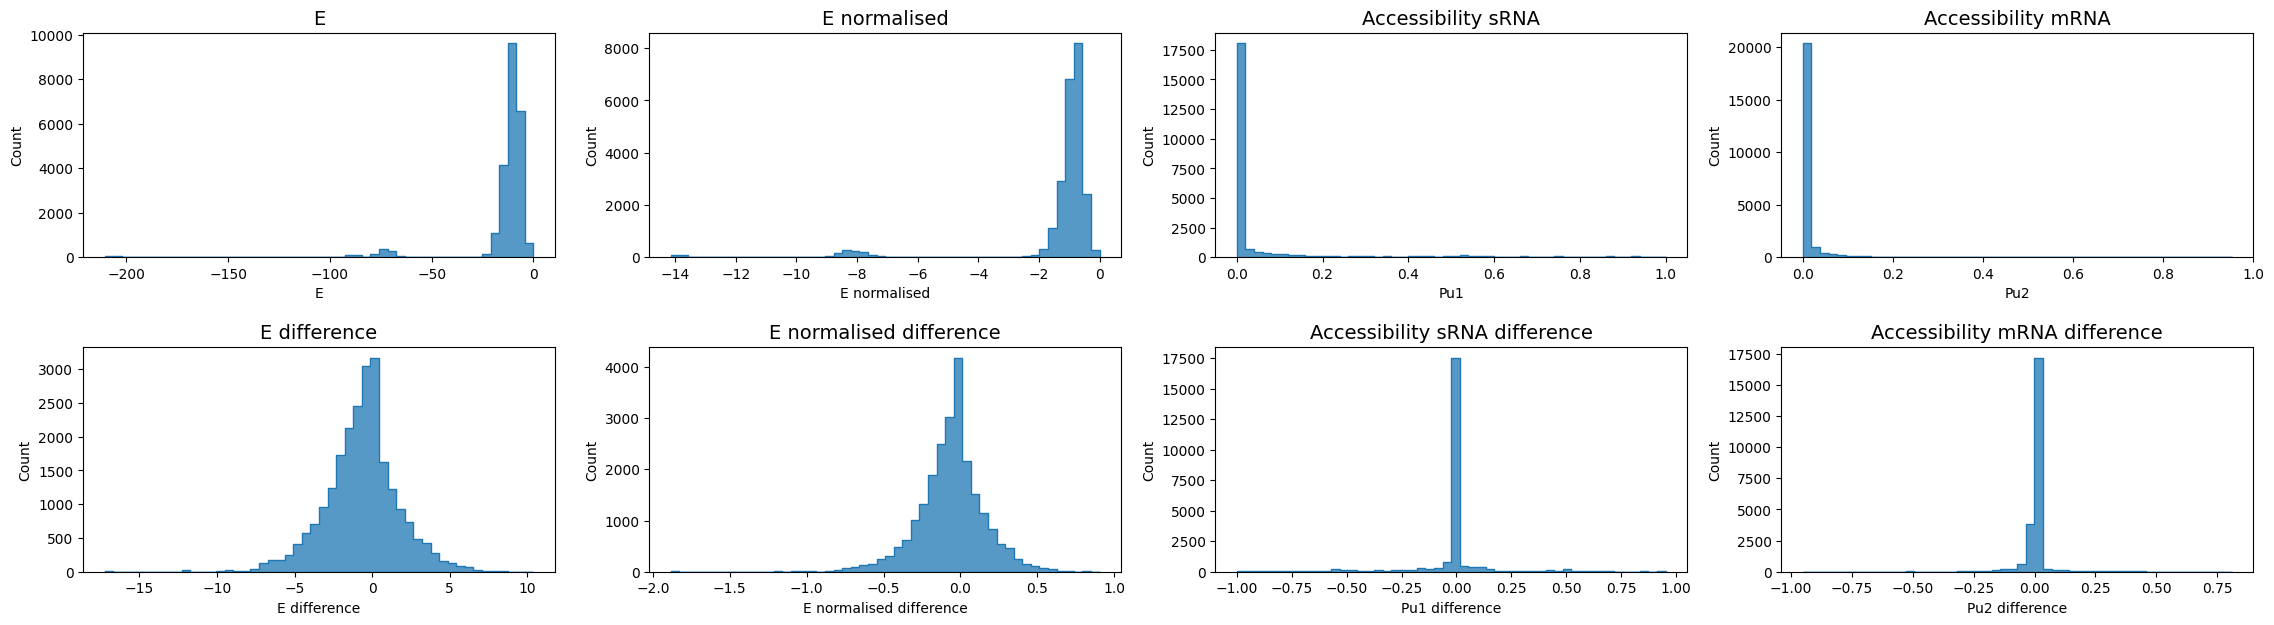

In [26]:
fig = plt.figure(figsize=(7*len(e_cols), 7))
fig.subplots_adjust(hspace=0.4)
i = 0
for a in ['', '_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.histplot(saves, x=e + a, bins=50, element='step')
        plt.xlabel(e.replace('norm', 'normalised').replace('_', ' ') + (' difference' if a else ''))
        plt.title(e.replace('Pu', 'Accessibility ').replace('1', 'sRNA').replace('2', 'mRNA').replace('norm', 'normalised').replace('_', ' ') + (' difference' if a else ''), fontsize=14)
        i = i+1
    

In [27]:
saves[saves['E'] < -50]['circuit_name'].unique()

array(['sibB_ibsB', 'sibC_ibsC', 'sibA_ibsA', 'sibD_ibsD', 'sibE_ibsE',
       'AfaR_afaD', 'mntS_yliL'], dtype=object)

## By binding site

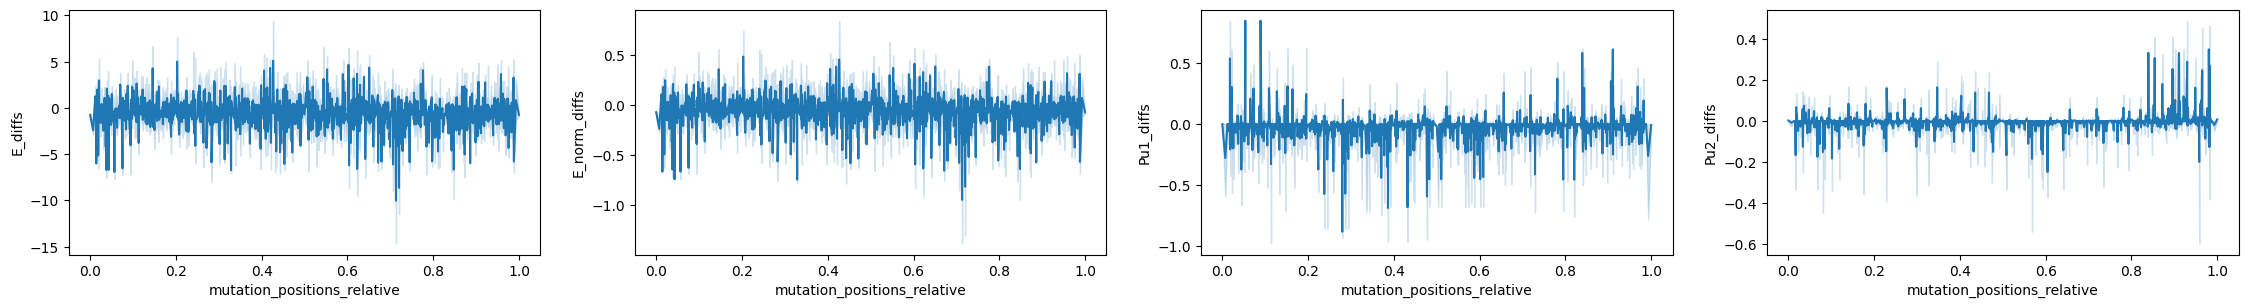

In [28]:
fig = plt.figure(figsize=(7*len(e_cols), 7))
i = 0
for a in ['_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.lineplot(saves, x='mutation_positions_relative', y=e+a)
        i = i+1
    

In [29]:
# saves['circuit_name'].apply(lambda x: x.split('_')[0]).unique()
# sorted(saves['circuit_name'].unique())

In [30]:
def combine_dictionaries(list_of_dicts):
    combined_dict = {}
    for d in list_of_dicts:
        combined_dict.update(d)
    return combined_dict


reverse_mapping = combine_dictionaries([{v: k for k, v in vv.items()} for vv in mutation_type_mapping_RNA.values()])

saves['Mutation type'] = saves['mutation_types'].apply(lambda x: reverse_mapping[x] if not np.isnan(x) else None)



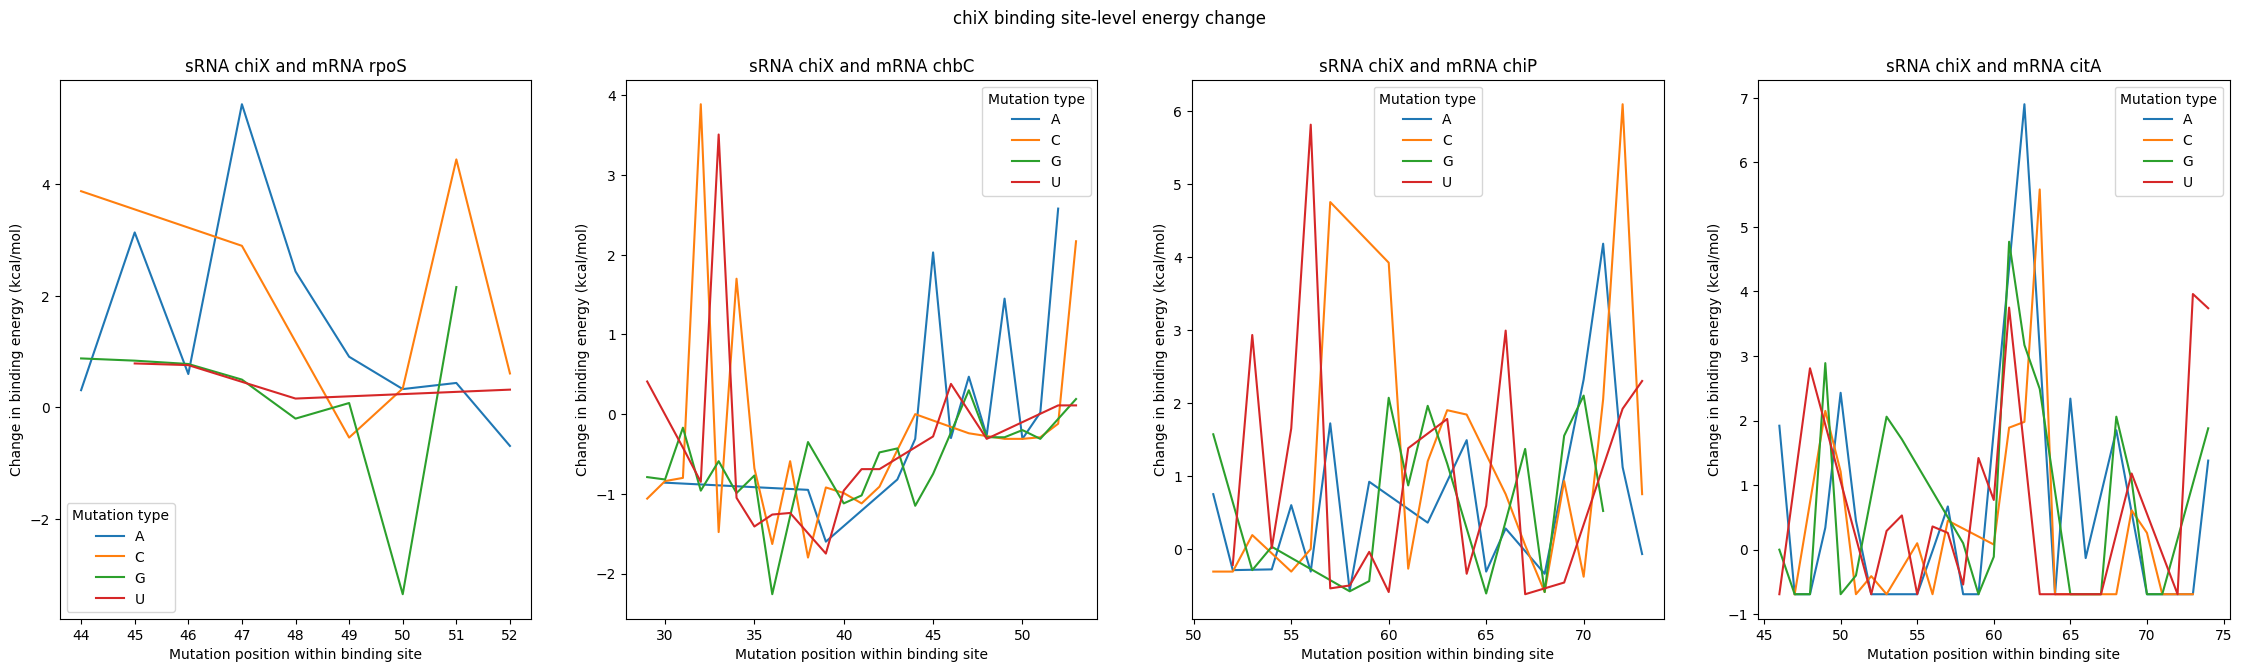

In [31]:
c = saves['circuit_name'].unique()[2]
cs = saves[saves['id1'] == 'chiX']['circuit_name'].unique()
plt.figure(figsize=(7*len(cs), 7))
for i, c in enumerate(cs):
    ax = plt.subplot(1, len(cs), i+1)
    sns.lineplot(saves[saves['circuit_name'] == c], x='mutation_positions', y=f'{e_col}_diffs', hue='Mutation type', hue_order=sorted(set(reverse_mapping.values())))
    plt.title(f'sRNA {c.replace("_", " and mRNA ")}')
    plt.xlabel('Mutation position within binding site')
    plt.ylabel('Change in binding energy (kcal/mol)')
    
plt.suptitle('chiX binding site-level energy change')

plt.savefig('data/figs/mutations_energy_chix.jpg')

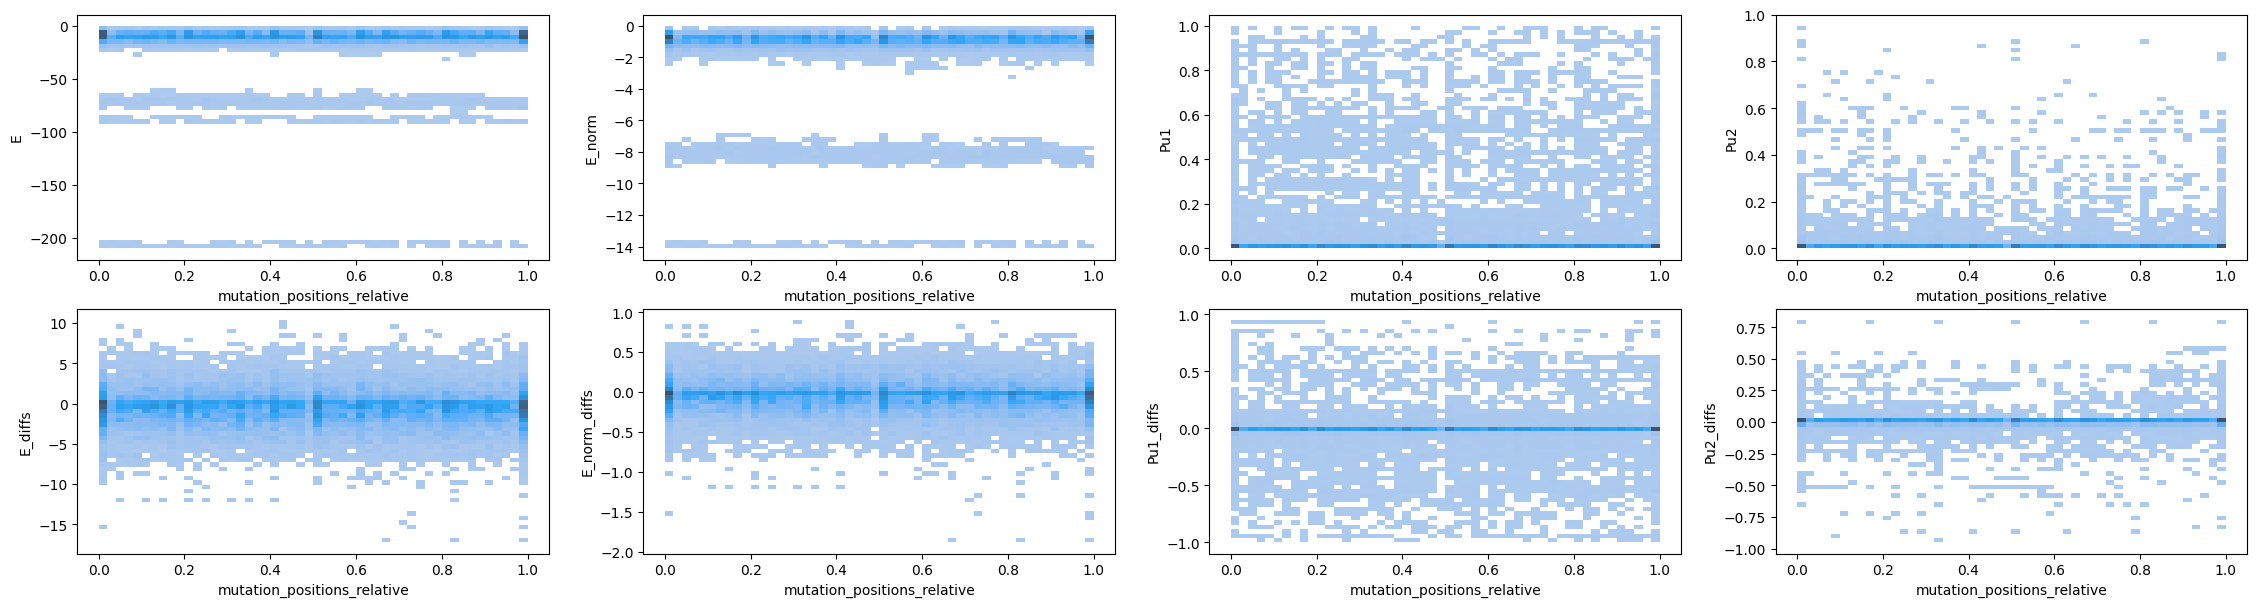

In [411]:
fig = plt.figure(figsize=(7*len(e_cols), 7))
i = 0
for a in ['', '_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.histplot(saves, x='mutation_positions_relative', y=e+a, bins=50) #, color=sns.color_palette("mako_r", 6)[4])
        i = i+1
    

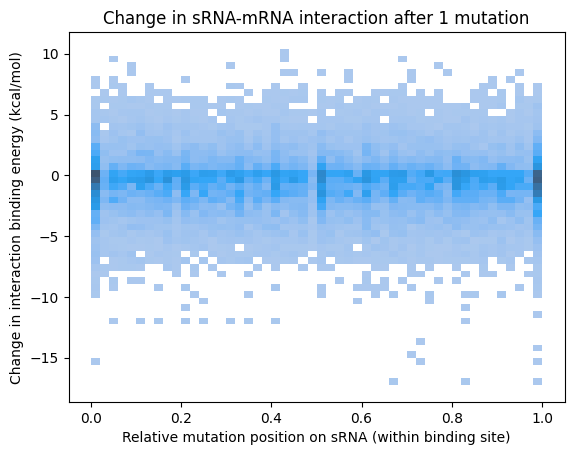

In [32]:

sns.histplot(saves, x='mutation_positions_relative', y=f'{e_col}_diffs', bins=50)
plt.xlabel('Relative mutation position on sRNA (within binding site)')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_binding_site.jpg')

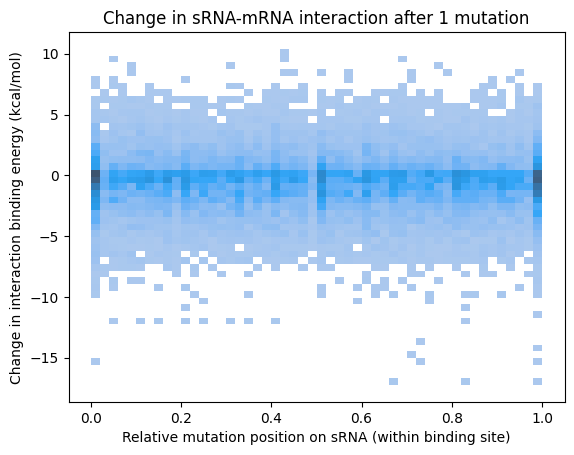

In [33]:

sns.histplot(saves[saves[e_col] < 0], x='mutation_positions_relative', y=f'{e_col}_diffs', bins=50)
plt.xlabel('Relative mutation position on sRNA (within binding site)')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_binding_site_without_noninteractors.jpg')

## By type

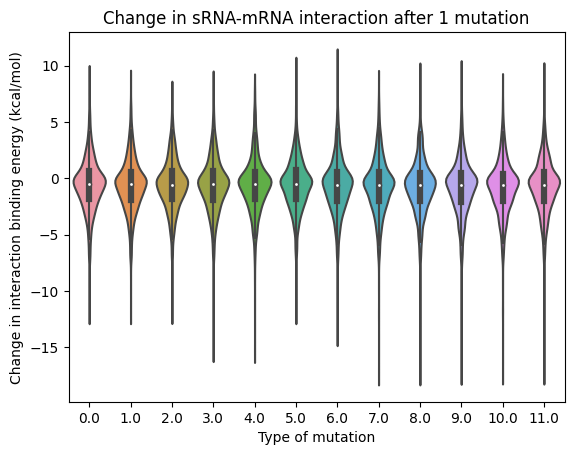

In [34]:
# sns.lineplot(saves, x='mutation_types', y=f'{e_col}_diffs')
sns.violinplot(saves, x='mutation_types', y=f'{e_col}_diffs')
# sns.histplot(saves, x='mutation_types', y=f'{e_col}_diffs', bins=50)
plt.xlabel('Type of mutation')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_mut_type.jpg') 

## Robustness

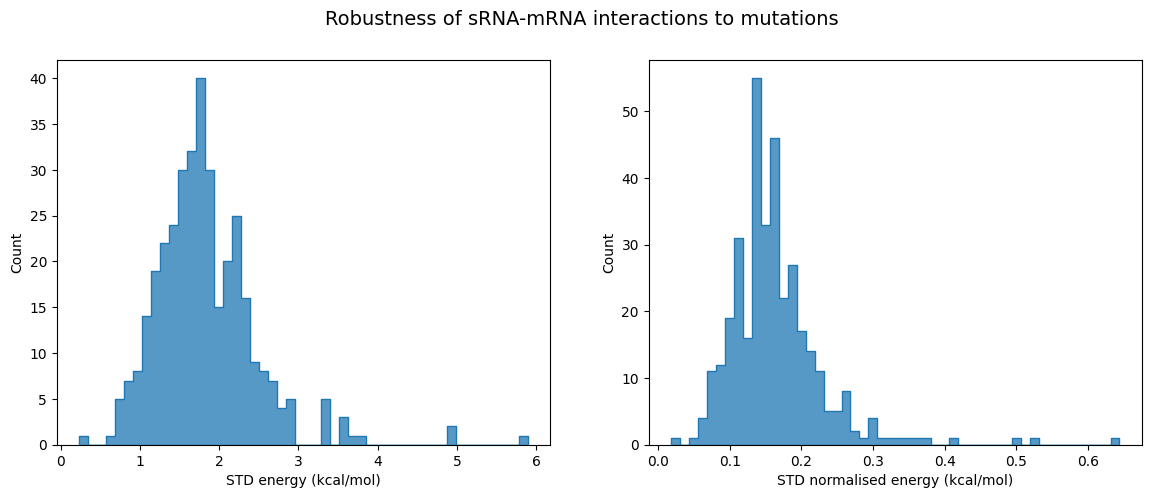

In [64]:
grouped = saves.groupby(by='circuit_name')

fig = plt.figure(figsize=(7*2, 5))

ax = plt.subplot(1,2,1)
sns.histplot(grouped[e_col].std(), bins=50, element='step')
plt.xlabel('STD energy (kcal/mol)')

ax = plt.subplot(1,2,2)
sns.histplot(grouped['E_norm'].std(), bins=50, element='step')
plt.xlabel('STD normalised energy (kcal/mol)')

plt.suptitle('Robustness of sRNA-mRNA interactions to mutations', fontsize=14)

plt.savefig('data/figs/mutations_energy_robust.jpg')

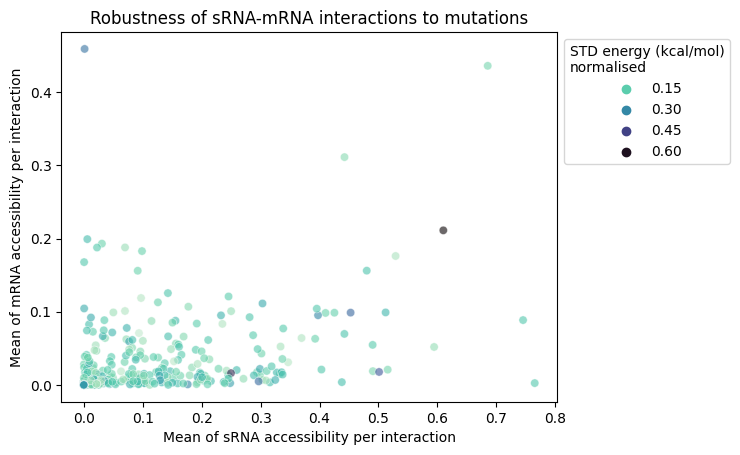

In [47]:
g = sns.scatterplot(x=grouped['Pu1'].mean(), y=grouped['Pu2'].mean(), hue=grouped['E_norm'].std(), alpha=0.6, palette='mako_r')
g.legend_.set_title('STD energy (kcal/mol)\nnormalised')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.title('Robustness of sRNA-mRNA interactions to mutations')
# plt.xlabel('STD ' + e_col)
plt.xlabel('Mean of sRNA accessibility per interaction')
plt.ylabel('Mean of mRNA accessibility per interaction')

plt.savefig('data/figs/mutations_energy_robust.jpg')

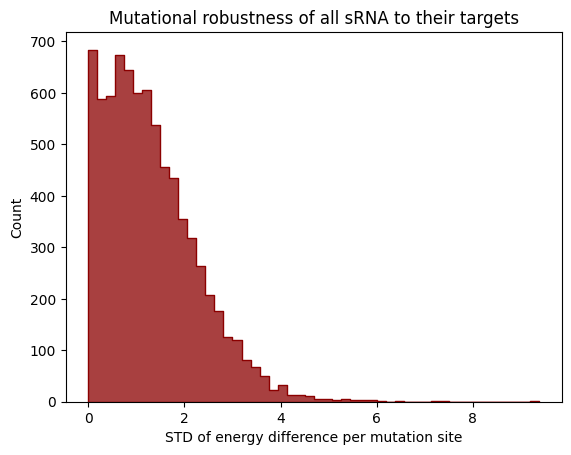

In [48]:
sns.histplot(saves[saves['mutation_name'] != 'ref_circuit'].groupby(by=['circuit_name', 'mutation_positions_relative'])[f'{e_col}_diffs'].std(), element='step', bins=50, color='darkred')
plt.xlabel('STD of energy difference per mutation site')
plt.title('Mutational robustness of all sRNA to their targets')
plt.savefig('data/figs/mutations_energy_std.jpeg')

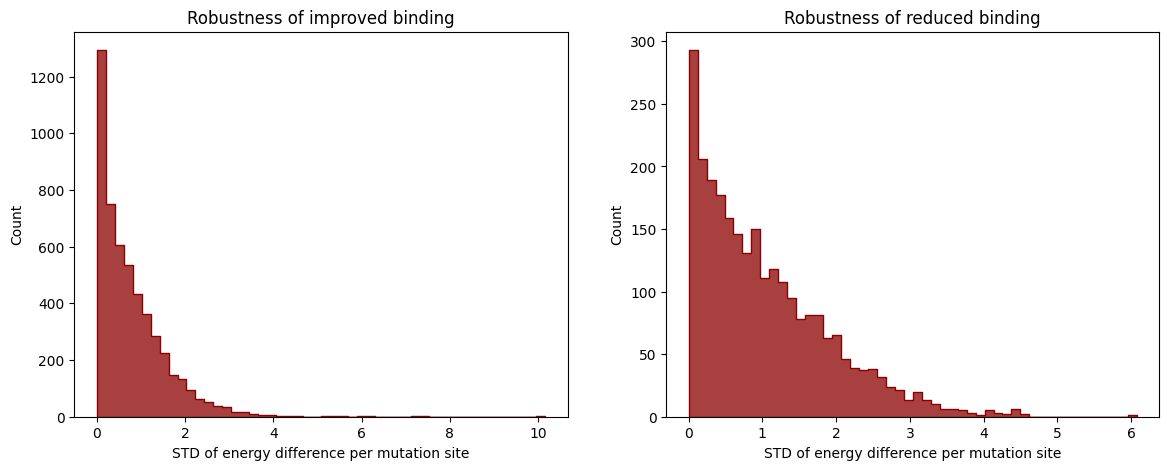

In [49]:
fig = plt.figure(figsize=(7*2, 5))

ax = plt.subplot(1,2,1)
sns.histplot(saves[saves[f'{e_col}_diffs'] < 0].groupby(by=['circuit_name', 'mutation_positions_relative'])[f'{e_col}_diffs'].std(), element='step', bins=50, color='darkred')
plt.xlabel('STD of energy difference per mutation site')
plt.title('Robustness of improved binding')

ax = plt.subplot(1,2,2)
sns.histplot(saves[saves[f'{e_col}_diffs'] >= 0].groupby(by=['circuit_name', 'mutation_positions_relative'])[f'{e_col}_diffs'].std(), element='step', bins=50, color='darkred')
plt.xlabel('STD of energy difference per mutation site')
plt.title('Robustness of reduced binding')
plt.savefig('data/figs/mutations_energy_negs_std.jpeg')


## Looking at most / least robust

In [62]:
b = (grouped['E_norm'].std() > (0.9*grouped['E_norm'].std().max()))
b.sort_values()[-sum(b):].index.to_list()

['sokB_mokB']

In [63]:
data[(data['Interactor 1'] == 'sokB') & (data['Interactor 2'] == 'mokB')]

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB,Genome position 1,Genome position 2,Strand 1,Strand 2,Sequence before 1,Sequence before 2,Sequence after 1,Sequence after 2
57,sokB,mokB,"chromosome:NC_000913.3, Gene ID:2847728","chromosome:NC_000913.3, Gene ID:948820",trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],GCTAGGTTCATTCGTTGGCCTCGGTTGATAGAAATATCGGTCGGGG...,ATGAACCTAGCAATTCAGATCTTAGCCTCTTACCCGCCATCCGGCA...,sRNATarBase,1492119..1492174,1491962..1492129,forward,reverse,TTGATTCCGTGGTTTGAAAGCTACCGGTAGCTTTTCATTCCTCTGC...,attcgttggcctcggttgatagaaatatcggtcggggccttcgtct...,TTGATTCCGTGGTTTGAAAGCTACCGGTAGCTTTTCATTCCTCTGC...,aaaggggggatctcacactgtacggcaggcggcaaatttgtctgta...
